## Neural Networks for Novices Activity
For the activity, you will try to pick hyperparameters of a MLP model to make it not overfit as much to the training data.

Upload your best score here: [https://keepthescore.com/board/qrqqhjgqwhxbe/](https://keepthescore.com/board/qrqqhjgqwhxbe/)

Tensorflow documentation: [https://www.tensorflow.org/api_docs/python/tf](https://www.tensorflow.org/api_docs/python/tf)

Keras documentation: [https://www.tensorflow.org/guide/keras](https://www.tensorflow.org/guide/keras)

Tip: For faster training times, set your runtime to T4 GPU under `Runtime > Change runtime type`. Luckily, Tensorflow conveniently manages simple GPU use cases like this under the hood.

In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seed
SEED = 100
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
# Google Colab
# DATA_PATH = "/content/datafiles"
# SAVE_PATH = "/content/models"


DATA_PATH = "/Users/trevoryu/Code/data/mnist"
SAVE_PATH = "/Users/trevoryu/Code/models/wat-ai"

# Obtain dataset
The dataset can be downloaded using Tensorflow datasets conveniently.

In [4]:
(train_dataset, val_dataset, test_dataset), ds_info = tfds.load(
    "mnist",
    split=["train[0:50_000]", "train[-10_000:]", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir=DATA_PATH
)
list(map(len, [train_dataset, val_dataset, test_dataset]))

[50000, 10000, 10000]

# Convert data into tensors
Loading from `tfds` already returns tensors, so if your data comes from other sources, you would need to do this. However, our data comes in `uint8` datatype, but most neural networks expect `float32`. Additionally, neural networks prefer data that comes from a random normal distribution, or scaled to between [-1, 1] or [0, 1]. We can scale the data easily to [0, 1] by dividing by 255, the maximum value of a `uint8`.

In [8]:
def preprocess(x, y):
    """
    Preprocess input data to neural network
    :param x: tf.Tensor image batch, of shape (B, 28, 28, 1)
    :param y: tf.Tensor labels, of shape (B,)

    :returns: (x, y), processed inputs of shapes ((B, 784), (B,))
    """
    # Rescale the data
    x = x / 255
    return x, y

In [9]:
# Apply the preprocessing to all the datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Define model architecture
Conveniently, Keras allows us to define a model as a sequence of layers. For a simple multi-layer perceptron, this is perfect, although more complex architectures can be made too using a similar API to PyTorch (come to Dive Into Deep Learning to learn more!). Keras also has a `Dense` layer that implements both the linear weight matrix, additive bias, and activation into one layer. Since the multi-layer perceptron is built of these three things, we can just use `Dense` layers. Note that since our inputs come in shape (28, 28, 1), we should flatten them first to a vector of length (784,) before passing them to the `Dense` layers.

Note that the output of the model will the log odds (or logits) of predicting each of the 10 classes. The index of the output with the highest probability is the class that would be selected.

In [10]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # tf.keras.layers.Dense(2048, activation="relu"),  # Dense layer of 2048 units
    tf.keras.layers.Dense(512, activation="relu"),  # Dense layer of 512 units
    tf.keras.layers.Dense(128, activation="relu"),  # Dense layer of 128 units
    tf.keras.layers.Dense(10)  # Output layer, 10 units, no activation
])

# Select hyperparameters
We'll use a batch size of 128, train for 20 epochs, and use an optimizer learning rate of 1e-3.

In [12]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-3

AUTOTUNE = tf.data.AUTOTUNE

For the loss function, `SparseCategoricalCrossentropy(from_logits=True)` implements softmax efficiently in the loss calculation, so we don't need to include a final softmax activation in the last layer. The corresponding metric for this classification problem is `SparseCategoricalAccuracy`. 

For the optimizer, `Adam` is a typical default deep learning optimizer and is a good starting point for many problems.

For the datasets, we need to batch and shuffle the training dataset. For the validation and test datasets, we don't need to shuffle, but we should still batch them.

In [13]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

train_dataset = train_dataset.cache().shuffle(buffer_size=train_dataset.cardinality(), seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In Tensorflow, we compile the model with the optimizer, loss, and metrics


In [15]:
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

Tensorflow has a convient training API with the `fit` method

In [16]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/20
391/391 [==============================] - 2s 4ms/step - loss: 0.2618 - sparse_categorical_accuracy: 0.9246 - val_loss: 0.1376 - val_sparse_categorical_accuracy: 0.9605
Epoch 2/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.1017 - val_sparse_categorical_accuracy: 0.9695
Epoch 3/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0611 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.0832 - val_sparse_categorical_accuracy: 0.9757
Epoch 4/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0770 - val_sparse_categorical_accuracy: 0.9773
Epoch 5/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0815 - val_sparse_categorical_accuracy: 0.9770
Epoch 6/20
391/391 [==============================] - 1s 3ms/step - loss: 0.0233 - sparse_categorica

The `history` object returned from `model.fit()` contains a lot of metrics that Tensorflow automatically records. We can plot them to visualize the training curves and see how well the model fit.

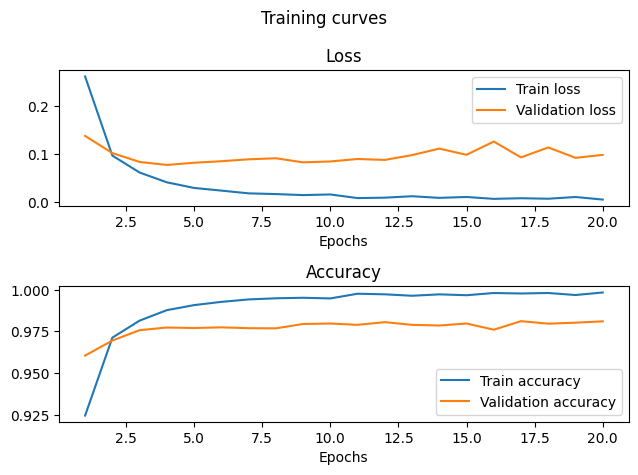

In [17]:
fig, axs = plt.subplots(2, 1)

labels = {
    "loss": "Train loss",
    "sparse_categorical_accuracy": "Train accuracy",
    "val_loss": "Validation loss",
    "val_sparse_categorical_accuracy": "Validation accuracy"
}

epochs = np.arange(EPOCHS) + 1

for key, metric in history.history.items():
    if "loss" in key:
        epochs = np.arange(len(metric)) + 1
        axs[0].plot(epochs, metric, label=labels[key])
    else:
        axs[1].plot(epochs, metric, label=labels[key])

for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")

axs[0].set_title("Loss")
# axs[0].set_ylim(-0.05, 0.5)
axs[1].set_title("Accuracy")
plt.suptitle("Training curves")
plt.tight_layout()
plt.show()

The model seems to have overfit by the end of 20 epochs. The validation loss is going up, and the accuracy is fluctuating. The model's performance is a little based on chance, depending on where it was after the 20 epochs.

# Evaluate on the test set

We should always test our model on the testing dataset. Especially if we do hyperparameter tuning, it is not sufficient to just use two datasets, since we might adjust hyperparameters that best fit the validation data, but not some other realworld / held out data.

If we have labels, we can score the model with `model.evaluate()`.

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

79/79 [==============================] - 0s 3ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9815
Test loss: 0.086
Test accuracy: 98.15%


If we only have inputs, then we should use `model.predict()` instead. Remember that the model returns log probability scores (logits). So to obtain the class, we should use `argmax` to find the index of the most likely (highest probability) output neuron.